# 前年同期比の計算

by kenjisato

月次データや週次データ，四半期データを使うときには，周期性に注意する必要があります。

- ボーナス月は消費が大きいとか，
- 土日の売上が大きいとか，
- 転勤や転職による移動が増える第1四半期に不動産取引が増えるとか。

はじめから季節調整されているデータが手に入る場合もありますが，季節調整をしていない原系列を分析したい，特に変化率を計算したいときは，次の2パターンがあります。

- 季節調整をした上で前期比を取るか，
- 前年同期比を取る（週次データなら前週の同じ曜日を比較して変化率を計算）

季節の移ろいでおこる自然な変化に騙されないようにしないといけないのですね。

さて，「前年同期比」を pandas で計算してみましょう。まずはいつものインポート文です。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr

/usr/local/var/pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### インデックス

Pandas の インデックスの知識が必要になるので，簡単に紹介します。Pandas の「インデックス」というのは行のラベルのことです。数字だったり，文字列だったりします。時系列データの場合は，

- 日時
- 日
- 月
- 四半期
- 年

などが使われます。

実例を見てみましょう。以下の2つのデータは FRED から取得できます。

- UNRATENSA: アメリカの失業率の原系列, 月次データ
- GFDEBTN: アメリカの公的債務残高, 四半期データ

In [2]:
unemp = pdr.get_data_fred("UNRATENSA", start="1960-01-01")
fdbt = pdr.get_data_fred("GFDEBTN", start="2005-01-01")

失業率は「1ヶ月の平均」というような値なのですが，"1960-01-01" のように具体的な日付がインデックスになっています。インデックスだけを見るには `.index` をつけるだけです。

In [3]:
unemp

,UNRATENSA
DATE,
1960-01-01,6.1
1960-02-01,5.7
1960-03-01,6.1
1960-04-01,5.2
1960-05-01,4.8
...,...
2020-01-01,4.0
2020-02-01,3.8
2020-03-01,4.5


In [4]:
unemp.index

DatetimeIndex(['1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01',
               ...
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01'],
              dtype='datetime64[ns]', name='DATE', length=725, freq=None)

`dtype='datetime64[ns]'` となっています。要するに「その日その瞬間の失業率」のようなイメージですね。実際には1ヶ月間の調査結果の平均なので，少し実態と異なっています。

これでも大きな問題はないのですが，Pandas には「幅を持った期間」を表す PeriodIndex という型（クラス）が用意されていてるので，変換しておきます。

In [5]:
unemp.index = unemp.index.to_period()

In [6]:
unemp.index

PeriodIndex(['1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10',
             ...
             '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01',
             '2020-02', '2020-03', '2020-04', '2020-05'],
            dtype='period[M]', name='DATE', length=725, freq='M')

`dtype='period[M]'`, `freq='M'` となり，値も '1960-01' のように幅のある表示になっています。

In [7]:
unemp

,UNRATENSA
DATE,
1960-01,6.1
1960-02,5.7
1960-03,6.1
1960-04,5.2
1960-05,4.8
...,...
2020-01,4.0
2020-02,3.8
2020-03,4.5


一方，債務の方は「ある瞬間の残高」（ストック）なので変換をしないでおきましょう。

In [8]:
fdbt.index

DatetimeIndex(['2005-01-01', '2005-04-01', '2005-07-01', '2005-10-01',
               '2006-01-01', '2006-04-01', '2006-07-01', '2006-10-01',
               '2007-01-01', '2007-04-01', '2007-07-01', '2007-10-01',
               '2008-01-01', '2008-04-01', '2008-07-01', '2008-10-01',
               '2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01',
               '2010-01-01', '2010-04-01', '2010-07-01', '2010-10-01',
               '2011-01-01', '2011-04-01', '2011-07-01', '2011-10-01',
               '2012-01-01', '2012-04-01', '2012-07-01', '2012-10-01',
               '2013-01-01', '2013-04-01', '2013-07-01', '2013-10-01',
               '2014-01-01', '2014-04-01', '2014-07-01', '2014-10-01',
               '2015-01-01', '2015-04-01', '2015-07-01', '2015-10-01',
               '2016-01-01', '2016-04-01', '2016-07-01', '2016-10-01',
               '2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01',
               '2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01',
      

季節性を調べるために必要な最初の知識は，日付や期間のインデックスから，「年」，「月」とか「四半期」の情報を取り出すことができるということです。すごく便利です。

In [9]:
unemp.index.year

Int64Index([1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960,
            ...
            2019, 2019, 2019, 2019, 2019, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', name='DATE', length=725)

In [10]:
unemp.index.month

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
             8,  9, 10, 11, 12,  1,  2,  3,  4,  5],
           dtype='int64', name='DATE', length=725)

In [11]:
fdbt.index.quarter

Int64Index([1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2,
            3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4,
            1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1],
           dtype='int64', name='DATE')

`unemp` のデータから 3月分だけを取得するには次のようにすればよいのです。

In [12]:
unemp[unemp.index.month == 3]

,UNRATENSA
DATE,
1960-03,6.1
1961-03,7.7
1962-03,6.2
1963-03,6.3
1964-03,5.9
...,...
2016-03,5.1
2017-03,4.6
2018-03,4.1


前年同期比は次のように計算できます。

In [13]:
unemp[unemp.index.month == 3].pct_change()

,UNRATENSA
DATE,
1960-03,NaN
1961-03,0.262295
1962-03,-0.194805
1963-03,0.016129
1964-03,-0.063492
...,...
2016-03,-0.089286
2017-03,-0.098039
2018-03,-0.108696


これをすべての月について計算して，再度くっつける操作をします。

1. 分割
2. 計算
3. 再結合

は繰り返し実行される操作なので，pandas は標準的な方法を提供しています。

## pandas.DataFrame の groupby() メソッドについて

### Toy example (1)

簡単な例でみていきましょう。

In [14]:
frame = pd.DataFrame(np.arange(18).reshape(6, 3), columns=list('abc'))
frame

,a,b,c
0,0,1,2
1,3,4,5
2,6,7,8
3,9,10,11
4,12,13,14
5,15,16,17


例えば，`a` 列が偶数かそうでないかで行をグループ分けしたい，としましょう。偶数か奇数は次のようにしてチェックできます。

In [15]:
frame.a % 2 == 0

0     True
1    False
2     True
3    False
4     True
5    False
Name: a, dtype: bool

この Series オブジェクトを `groupby()` メソッドに渡してやればよいです。

In [16]:
grouped = frame.groupby(frame.a % 2 == 0)
grouped

中身が見えないので，何がなんだか分かりませんね。グループ化した後のオブジェクトは辞書のようなオブジェクトになっています（ただし辞書ではない）。

つまり，キーと値のペアから構成されます。

- キー ＝ グループ化条件
- 値 ＝ グループ化条件に合うサブデータフレーム

for でループすると中身を見ることができます。

In [17]:
print("-" * 13) # 結果を見やすくするために入れた

for i, group in grouped:
    print(i)
    print("-" * 13)  
    
    print(group)
    print("-" * 13)

-------------
False
-------------
    a   b   c
1   3   4   5
3   9  10  11
5  15  16  17
-------------
True
-------------
    a   b   c
0   0   1   2
2   6   7   8
4  12  13  14
-------------


サブデータフレームを取得するには `get_group()` というメソッドを使います。

In [18]:
grouped.get_group(True)

,a,b,c
0,0,1,2
2,6,7,8
4,12,13,14


一番重要なのは，サブグループの列に対していろいろな操作ができることです。例を見てみましょう。

`mean()`, `sum()` などの基本的なメソッドが使えます。

In [19]:
grouped.mean()

,a,b,c
a,,,
False,9,10,11
True,6,7,8


- 最初に「`a` 列が奇数か偶数か」というグループ分けをしたので結果のデータフレームのインデックスの名前が `a`，値が `False`, `True` になります。
- 各列は `False` グループ，`True` グループのそれぞれについて平均を取ったものになります。

もっと複雑な集計計算は `apply()` メソッドを使って行います。

In [20]:
grouped.apply(lambda x: 3 * np.mean(x))

,a,b,c
a,,,
False,27.0,30.0,33.0
True,18.0,21.0,24.0


### Toy example (2)

上の例では `groupby()` メソッドに Series オブジェクト（データフレームの列）を渡しました。Series オブジェクトの値に応じて行をグループ分けします。 

`groupby()` には列名を渡すこともできます。この使用方法も見ておきましょう。

In [21]:
rng = np.random.default_rng(123)
frame2 = pd.DataFrame({'x': rng.choice(range(10), 20),
                       'y': np.arange(20)})
frame2.head()

,x,y
0,0,0
1,6,1
2,5,2
3,0,3
4,9,4


`frame2.groupby('x')` という形式でグループ化ができます。

In [22]:
frame2.groupby('x').get_group(3)

,x,y
8,3,8
10,3,10


In [23]:
print("-" * 10) # 結果を見やすくするために入れた

for i, group in frame2.groupby('x'):
    print(f"x = {i}")
    print("-" * 10)  
    
    print(group)
    print("-" * 10)

----------
x = 0
----------
   x  y
0  0  0
3  0  3
----------
x = 1
----------
   x  y
7  1  7
9  1  9
----------
x = 2
----------
    x   y
5   2   5
6   2   6
15  2  15
----------
x = 3
----------
    x   y
8   3   8
10  3  10
----------
x = 4
----------
    x   y
12  4  12
14  4  14
----------
x = 5
----------
   x  y
2  5  2
----------
x = 6
----------
   x  y
1  6  1
----------
x = 7
----------
    x   y
16  7  16
----------
x = 8
----------
    x   y
11  8  11
17  8  17
18  8  18
19  8  19
----------
x = 9
----------
    x   y
4   9   4
13  9  13
----------


集計関数を使ってみよう。 `x` 列が自動的に消去されていることがわかる。（列に戻したいときは `reset_index()` を使う）


In [24]:
frame2.groupby("x").mean()

,y
x,
0,1.500000
1,8.000000
2,8.666667
3,9.000000
4,13.000000
5,2.000000
6,1.000000
7,16.000000
8,16.250000


最後に，`agg()`, `aggregate()`というメソッドを紹介します。

グループ化する列以外の各列に対して複数の集計関数を一気に適用することができます。

In [25]:
frame2.groupby("x").aggregate(['min', 'max', np.std])

y              
  min max       std
x                  
0   0   3  2.121320
1   7   9  1.414214
2   5  15  5.507571
3   8  10  1.414214
4  12  14  1.414214
5   2   2       NaN
6   1   1       NaN
7  16  16       NaN
8  11  19  3.593976
9   4  13  6.363961

詳しくは『Python によるデータ分析入門 第2版』または [Pandas のマニュアル](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)を見てください。

## 季節性のチェックと変化率

### 失業率原系列

失業率に季節性があるかを見てみましょう。目視でチェックしたいので，


- 年でグループ化して，
- 横軸を「月」，縦軸が「失業率」になるようなプロットを描く

ということをやります。なんとなく，4月ごろに下がって，年末から年始にかけて上昇，7月も上昇という傾向がありそうです。


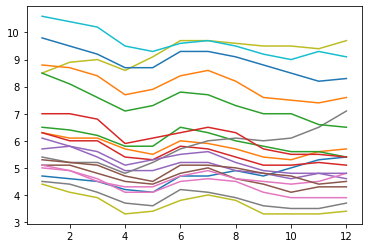

In [26]:
unemp19 = unemp[(unemp.index.year < 2020) & (unemp.index.year > 2000)]
fig, ax = plt.subplots(1)

for year, data in unemp19.groupby(unemp19.index.year):
    ax.plot(range(1, 13), data, label=year)

handles, labels = ax.get_legend_handles_labels()

このようなデータに対して前月からの変化を取るとよくわからない結果になります。季節変動も拾ってしまうからです。

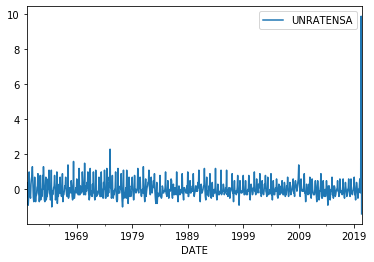

In [27]:
unemp.diff().plot();

そこで，前年同期比を取ります。これには

- 月でグループ化
- グループ内で変化率 (`pct_change()` あるいは `diff()`) を計算する

ということをやればよいです。もともとパーセントなので，`diff()` を取ってみましょう。

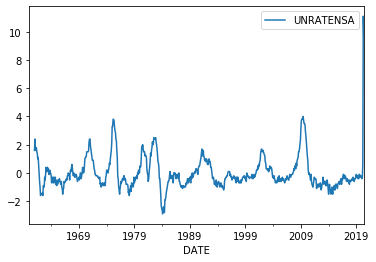

In [28]:
unemp.groupby(unemp.index.month).apply(lambda x: x.diff()).plot();

不況の時期に失業率が上昇することが見やすくなります。

### 連邦債務

連邦債務の方もチェックしてみましょう。

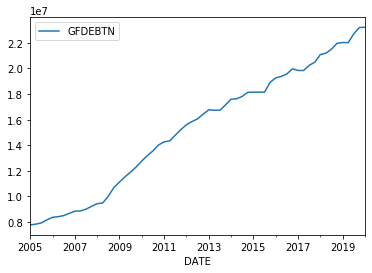

In [29]:
fdbt.plot();

連邦債務の上限を超える国際発行には議会の承認が必要なので，議会運営のサイクル（連邦予算のサイクル）と債務増加のサイクルが連動していることが予想されます。

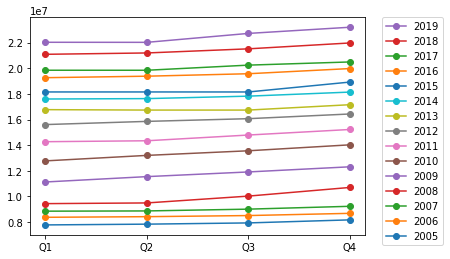

In [30]:
fdbt19 = fdbt[fdbt.index.year < 2020]
fig, ax = plt.subplots(1)

for year, data in fdbt19.groupby(fdbt19.index.year):
    ax.plot(['Q1', 'Q2', 'Q3', 'Q4'], data, marker='o', label=year)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1), 
          loc='upper left', borderaxespad=0);

失業率のケースよりは問題は少ないようですが，それでも季節変動を拾ってしまいややギザギザした印象を受けます。

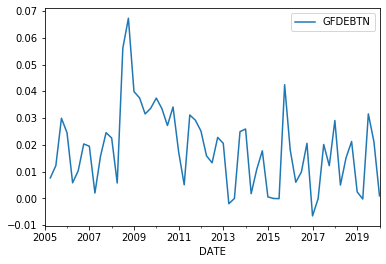

In [31]:
fdbt.pct_change().plot()

前年同期比を取るとこの問題が軽減されて，その年の「異常」な動きを補足しやすくなります。

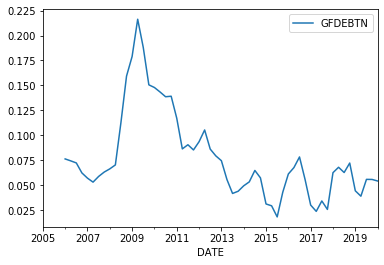

In [32]:
fdbt.groupby(fdbt.index.quarter).pct_change().plot()

## おわりに

FRED では季節調整されているデータが多いので，"Not seasonally adjusted" というキーワードで検索すると，練習用のデータを見つけやすいと思います。